In [24]:
! pip install -q tsai

In [25]:
! pip install -q mplfinance

##Import libraries

In [26]:
import os
from pathlib import Path
import pandas as pd
import sklearn
from tsai.basics import *
from tsai.models import PatchTST
from tsai.metrics import mse, mae
from fastai.callback.tracker import EarlyStoppingCallback
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, accuracy_score, precision_score, mean_absolute_percentage_error, r2_score
import numpy as np
import mplfinance as mpf

### Defin indexes





In [27]:
def compute_rsi(prices, period=14):
    """
    Compute the Relative Strength Index (RSI) for a series of prices.
    Returns a 1D numpy array of RSI values. The first (period-1) values will be NaN.
    """
    prices = np.array(prices)
    deltas = np.diff(prices)
    seed = deltas[:period]
    up = seed[seed >= 0].sum() / period
    down = -seed[seed < 0].sum() / period
    rs = up / down if down != 0 else 0
    rsi = np.zeros_like(prices)
    rsi[:period] = np.nan
    rsi[period - 1] = 100. - 100. / (1. + rs)
    for i in range(period, len(prices)):
        delta = deltas[i - 1]
        if delta > 0:
            upval = delta
            downval = 0
        else:
            upval = 0
            downval = -delta
        up = (up * (period - 1) + upval) / period
        down = (down * (period - 1) + downval) / period
        rs = up / down if down != 0 else 0
        rsi[i] = 100. - 100. / (1. + rs)
    return rsi

def compute_macd(prices, fast=12, slow=26, signal=9):
    """
    Compute the MACD (Moving Average Convergence Divergence) for a series of prices.
    Returns a tuple of three 1D numpy arrays: (macd, signal_line, histogram).
    """
    prices = pd.Series(np.array(prices).flatten())
    ema_fast = prices.ewm(span=fast, adjust=False).mean()
    ema_slow = prices.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    histogram = macd - signal_line
    return macd.values, signal_line.values, histogram.values

In [28]:
csv_file_path = '/content/bit_sen.csv'

# Extract base name without extension for naming
csv_base = Path(csv_file_path).stem

# Define paths for saving the best model and its metrics
model_history_dir = Path('model_history')
result_history_dir = Path('result_history')

os.makedirs(model_history_dir, exist_ok=True)
os.makedirs(result_history_dir, exist_ok=True)

best_model_filename = f"{csv_base}_best_model.pt"
best_model_path = model_history_dir / best_model_filename
metrics_path = result_history_dir / f"{csv_base}_metrics.txt"

forecast_history = 24  # Number of past time steps to use for input sequences.
forecast_horizon = 1  # Number of future time steps to predict (e.g., 0 means predicting the next step immediately).

batch_size = 64  # Number of samples in each mini-batch
max_iterations = 10
model_name = 'PatchTST'

target='price' # or  'rsi'
best_mse = float('inf')
best_metric = float('inf')

###Preprocess

In [29]:
# Load Data
try:
  df_raw = pd.read_csv(csv_file_path)
  print("CSV file loaded successfully.")
except Exception as e:
  print(f"Error reading CSV file: {e}")

df_raw.head(10)

CSV file loaded successfully.


,positive,negetive,neutral,Date,Price,Open,High,Low,Vol.,Change %
0,0.116094,0.789252,0.094654,2015-01-01,313.9,317.5,317.5,312.9,0.93K,-0.99%
1,0.113846,0.795338,0.090816,2015-01-02,315.1,313.6,316.0,313.0,1.32K,0.40%
2,0.114822,0.795150,0.090027,2015-01-03,282.0,314.8,314.8,282.0,1.30K,-10.51%
3,0.114798,0.790363,0.094839,2015-01-04,258.8,282.0,288.9,258.8,2.38K,-8.23%
4,0.117028,0.790906,0.092066,2015-01-05,273.2,261.0,276.5,260.5,2.68K,5.57%
5,0.113413,0.791942,0.094645,2015-01-06,285.4,273.2,287.8,268.5,6.86K,4.46%
6,0.117202,0.788809,0.093989,2015-01-07,297.0,286.1,303.8,285.0,1.53K,4.07%
7,0.114490,0.784668,0.100843,2015-01-08,285.6,296.2,296.2,285.6,1.31K,-3.82%
8,0.111742,0.798039,0.090218,2015-01-09,292.8,285.4,295.6,283.0,1.26K,2.52%
9,0.113061,0.791843,0.095096,2015-01-10,275.0,292.4,292.4,271.0,1.11K,-6.08%


In [30]:
# Preprocess data
datetime_col = "Date"
freq = '1D'
price_col = 'Price'
columns = [price_col]
method = 'ffill'
value = 0


# Define a data preprocessing pipeline
preproc_pipe = sklearn.pipeline.Pipeline([
            ('shrinker', TSShrinkDataFrame()),
            ('drop_duplicates', TSDropDuplicates(datetime_col=datetime_col)),
            ('add_mts', TSAddMissingTimestamps(datetime_col=datetime_col, freq=freq)),
            ('fill_missing', TSFillMissing(columns=columns, method=method, value=value)),
        ], verbose=False)

# Apply the pipeline to the raw data
df = preproc_pipe.fit_transform(df_raw)

# Convert the datetime column to a standard datetime format
df[datetime_col] = pd.to_datetime(df[datetime_col])

# Sort the data by the datetime column in ascending order
df = df.sort_values(by=datetime_col)



Initial memory usage: 139.66 KB 
Final memory usage  : 153.39 KB  (9.8%)


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1788 entries, 0 to 1787
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1788 non-null   datetime64[ns]
 1   positive  1786 non-null   float32       
 2   negetive  1786 non-null   float32       
 3   neutral   1786 non-null   float32       
 4   Price     1788 non-null   float32       
 5   Open      1786 non-null   float32       
 6   High      1786 non-null   float32       
 7   Low       1786 non-null   float32       
 8   Vol.      1776 non-null   category      
 9   Change %  1786 non-null   category      
dtypes: category(2), datetime64[ns](1), float32(7)
memory usage: 153.5 KB


In [32]:
# For RSI prediction, add the RSI column
if target == 'rsi':
    df['RSI'] = compute_rsi(df[price_col].values, period=14)

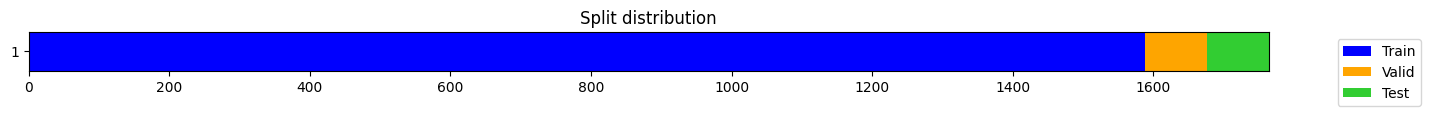

Data splitting into train, validation, and test sets.


In [33]:
# Define the proportions for test and validation sets
test_size = 0.05  # Fraction of the data to be used as the test set
valid_size = 0.05 # Fraction of the data to be used as the validation set

# Define forecasting splits

splits = get_forecasting_splits(
      df,
      fcst_history=forecast_history,
      fcst_horizon=forecast_horizon,
      datetime_col=datetime_col,
      valid_size=valid_size,
      test_size=test_size
  )

# Print the sizes of each split for verification
print("Data splitting into train, validation, and test sets.")


In [34]:
# Create scaling pipeline
# (For both targets, we scale the price column)
scale_columns = [price_col]
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=scale_columns)),
              ], verbose=False)

df_scaled = exp_pipe.fit_transform(df, scaler__idxs=splits[0])


# Print a message indicating that the scaling is complete
print("Data scaling completed.")


Data scaling completed.


In [35]:
df_scaled

,Date,positive,negetive,neutral,Price,Open,High,Low,Vol.,Change %
0,2015-01-01,0.116094,0.789252,0.094654,-0.792742,317.500000,317.500000,312.899994,0.93K,-0.99%
1,2015-01-02,0.113846,0.795338,0.090816,-0.792411,313.600006,316.000000,313.000000,1.32K,0.40%
2,2015-01-03,0.114822,0.795150,0.090027,-0.801555,314.799988,314.799988,282.000000,1.30K,-10.51%
3,2015-01-04,0.114798,0.790363,0.094839,-0.807963,282.000000,288.899994,258.799988,2.38K,-8.23%
4,2015-01-05,0.117028,0.790906,0.092066,-0.803985,261.000000,276.500000,260.500000,2.68K,5.57%
...,...,...,...,...,...,...,...,...,...,...
1783,2019-11-19,0.210475,0.532893,0.256632,1.376032,8219.500000,8241.900391,8055.200195,3.70K,-0.66%
1784,2019-11-20,0.223350,0.554299,0.222351,1.365397,8164.899902,8255.000000,8081.000000,2.06K,-0.47%
1785,2019-11-21,0.306655,0.399242,0.294104,1.239624,8126.399902,8155.899902,7510.100098,9.89K,-5.60%
1786,2019-11-22,0.202748,0.585070,0.212181,1.143464,7672.500000,7763.299805,6820.100098,19.37K,-4.54%


In [36]:
# Set the features and targets
if target == 'price':
    x_vars = [price_col ]
    y_vars = [price_col]
elif target == 'rsi':
    x_vars = [price_col]
    y_vars = ['RSI']


X, y = prepare_forecasting_data(
            df_scaled,
            fcst_history=forecast_history,
            fcst_horizon=forecast_horizon,
            x_vars=x_vars,
            y_vars=y_vars
        )

###Define model

In [37]:
# Define model architecture configuration
arch_config = dict(
    n_layers=3,
    n_heads=4,
    d_model=16,
    d_ff=128,
    attn_dropout=0.1,
    dropout=0.3,
    patch_len=9,
    stride=2,
    padding_patch=True
)


###Train

In [38]:
def log_print(*args, **kwargs):
    with open(metrics_path, 'a') as metrics_file:
        msg = ' '.join(map(str, args))
        print(msg)
        metrics_file.write(msg + '\n')

In [39]:
# Lists for storing training and validation metrics
train_mse_list = []
val_mse_list = []
final_learn = None  # Keep track of the last iteration's learner

In [42]:
X.shape, y.shape

((1764, 1, 24), (1764, 1, 1))

In [47]:
log_print(f"Model Name: {model_name}")
log_print(f"Sequence Length (Forecast History): {forecast_history}")
log_print(f"Forecast Horizon: {forecast_horizon}")
log_print(f"Training Started at: {pd.Timestamp.now()}")
for i in range(max_iterations):
      log_print(f"\nStarting training iteration {i + 1}/{max_iterations}")

      learn = TSForecaster(
          X,y,
          splits=splits,
          batch_size=24,
          path=model_history_dir,
          #pipelines=[preproc_pipe, exp_pipe],
          arch=model_name,
          arch_config=arch_config,
          metrics=[mse, mae],
          cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=20)]
      )

      learn.fit_one_cycle(max_iterations, lr_max=0.001)

      # Validate the model
      val_loss = learn.recorder.values[-1][1]
      val_mse = learn.recorder.values[-1][0]
      val_mse_list.append(val_mse)

      train_mse = learn.recorder.values[-1][2] if len(learn.recorder.values[-1]) > 2 else float('nan')
      if not np.isnan(train_mse):
          train_mse_list.append(train_mse)
      test_batch_size = len(X[splits[2]])
      scaled_preds_test, *_ = learn.get_X_preds(X[splits[2]], bs=test_batch_size)
      scaled_preds_test = to_np(scaled_preds_test).flatten()
      scaled_y_test = y[splits[2]].flatten()

      if target == 'price':
          preds_test = exp_pipe.named_steps['scaler'].inverse_transform(
              pd.DataFrame(scaled_preds_test.reshape(-1, 1), columns=scale_columns)
          ).values.flatten()
          actual_test = exp_pipe.named_steps['scaler'].inverse_transform(
              pd.DataFrame(scaled_y_test.reshape(-1, 1), columns=scale_columns)
          ).values.flatten()
      else:
          preds_test = scaled_preds_test
          actual_test = scaled_y_test

      test_metric = mean_squared_error(actual_test, preds_test)
      log_print(f"Iteration {i + 1}: Test MSE: {test_metric:.4f}, Validation MSE: {val_loss:.4f}")

      if test_metric < best_metric or (test_metric == best_metric and val_loss < best_val_loss):
              best_metric = test_metric
              best_val_loss = val_loss
              log_print(f"Exporting best model to '{best_model_path.resolve()}'")
              learn.export(str(best_model_path.resolve()))
              log_print(f"New best model saved with Test Metric {best_metric:.4f} and Validation MSE {best_val_loss:.4f}")


Model Name: PatchTST
Sequence Length (Forecast History): 24
Forecast Horizon: 1
Training Started at: 2025-05-20 14:15:42.676480

Starting training iteration 1/10


epoch,train_loss,valid_loss,mse,mae,time
0,0.048002,0.084562,0.084562,0.228597,00:05
1,0.029167,0.062888,0.062888,0.198106,00:01
2,0.025246,0.051155,0.051155,0.179723,00:01
3,0.018511,0.047866,0.047866,0.175008,00:01
4,0.016065,0.044794,0.044794,0.169224,00:01
5,0.015742,0.044074,0.044074,0.167950,00:01
6,0.015592,0.043312,0.043312,0.167659,00:02
7,0.015134,0.043625,0.043625,0.168655,00:02
8,0.014284,0.044135,0.044135,0.169906,00:01
9,0.014363,0.042623,0.042623,0.166886,00:01


Iteration 1: Test MSE: 235424.6875, Validation MSE: 0.0426
Exporting best model to '/content/model_history/bit_sen_best_model.pt'
New best model saved with Test Metric 235424.6875 and Validation MSE 0.0426

Starting training iteration 2/10


epoch,train_loss,valid_loss,mse,mae,time
0,0.059270,0.089438,0.089438,0.230088,00:01
1,0.035698,0.059656,0.059656,0.193766,00:01
2,0.023797,0.056083,0.056083,0.191500,00:01
3,0.018105,0.050007,0.050007,0.184452,00:01
4,0.015553,0.051097,0.051097,0.184067,00:02
5,0.015804,0.044070,0.044070,0.171322,00:02
6,0.016143,0.044450,0.044450,0.171443,00:01
7,0.015279,0.043750,0.043750,0.170172,00:01
8,0.017426,0.045757,0.045757,0.173136,00:01
9,0.014011,0.045105,0.045105,0.172100,00:01


Iteration 2: Test MSE: 238979.6406, Validation MSE: 0.0451

Starting training iteration 3/10


epoch,train_loss,valid_loss,mse,mae,time
0,0.043562,0.061825,0.061825,0.191209,00:01
1,0.027805,0.047605,0.047605,0.179083,00:01
2,0.020931,0.039301,0.039301,0.161490,00:01
3,0.018126,0.039205,0.039205,0.162604,00:02
4,0.017083,0.043934,0.043934,0.171085,00:01
5,0.014541,0.045011,0.045011,0.174465,00:01
6,0.016117,0.044862,0.044862,0.174530,00:01
7,0.015916,0.041249,0.041249,0.166930,00:01
8,0.014713,0.041601,0.041601,0.167004,00:01
9,0.015243,0.041373,0.041373,0.166402,00:01


Iteration 3: Test MSE: 225980.3594, Validation MSE: 0.0414
Exporting best model to '/content/model_history/bit_sen_best_model.pt'
New best model saved with Test Metric 225980.3594 and Validation MSE 0.0414

Starting training iteration 4/10


epoch,train_loss,valid_loss,mse,mae,time
0,0.043451,0.070609,0.070609,0.204261,00:01
1,0.027625,0.055489,0.055489,0.184460,00:02
2,0.023126,0.051913,0.051913,0.181918,00:02
3,0.021373,0.051429,0.051429,0.184157,00:01
4,0.019106,0.049045,0.049045,0.180894,00:01
5,0.017864,0.047693,0.047693,0.177553,00:01
6,0.016088,0.046775,0.046775,0.176682,00:01
7,0.013954,0.046912,0.046912,0.176521,00:01
8,0.013677,0.046354,0.046354,0.176169,00:01
9,0.015084,0.045964,0.045964,0.175796,00:01


Iteration 4: Test MSE: 262573.0312, Validation MSE: 0.0460

Starting training iteration 5/10


epoch,train_loss,valid_loss,mse,mae,time
0,0.046745,0.081154,0.081154,0.224723,00:02
1,0.030784,0.045218,0.045218,0.168889,00:01
2,0.022517,0.041078,0.041078,0.165649,00:01
3,0.018361,0.044290,0.044290,0.169414,00:01
4,0.016900,0.037430,0.037430,0.156369,00:01
5,0.017145,0.038140,0.038140,0.159182,00:01
6,0.015524,0.039163,0.039163,0.159125,00:02
7,0.014219,0.037569,0.037569,0.156716,00:02
8,0.015284,0.037544,0.037544,0.156490,00:02
9,0.013315,0.037427,0.037427,0.156296,00:01


Iteration 5: Test MSE: 225798.0000, Validation MSE: 0.0374
Exporting best model to '/content/model_history/bit_sen_best_model.pt'
New best model saved with Test Metric 225798.0000 and Validation MSE 0.0374

Starting training iteration 6/10


epoch,train_loss,valid_loss,mse,mae,time
0,0.047364,0.089938,0.089938,0.230407,00:01
1,0.031562,0.054821,0.054821,0.188249,00:01
2,0.021952,0.049408,0.049408,0.181595,00:01
3,0.018161,0.046568,0.046568,0.178141,00:01
4,0.017501,0.050016,0.050016,0.183485,00:01
5,0.014306,0.049820,0.049820,0.180964,00:01
6,0.014395,0.043177,0.043177,0.170193,00:02
7,0.012646,0.043204,0.043204,0.170506,00:02
8,0.013055,0.042512,0.042512,0.168985,00:01
9,0.013213,0.042623,0.042623,0.169311,00:01


Iteration 6: Test MSE: 267930.7812, Validation MSE: 0.0426

Starting training iteration 7/10


epoch,train_loss,valid_loss,mse,mae,time
0,0.049704,0.074766,0.074766,0.210208,00:01
1,0.026726,0.055265,0.055265,0.185491,00:01
2,0.020509,0.046691,0.046691,0.177126,00:02
3,0.016880,0.045000,0.045000,0.170461,00:01
4,0.016825,0.045709,0.045709,0.172438,00:02
5,0.016971,0.041287,0.041287,0.164794,00:02
6,0.015107,0.043121,0.043121,0.170077,00:01
7,0.014513,0.040772,0.040772,0.164624,00:01
8,0.015347,0.041785,0.041785,0.166738,00:01
9,0.014294,0.042004,0.042004,0.166804,00:01


Iteration 7: Test MSE: 238255.7969, Validation MSE: 0.0420

Starting training iteration 8/10


epoch,train_loss,valid_loss,mse,mae,time
0,0.042771,0.058825,0.058825,0.182395,00:01
1,0.026656,0.040842,0.040842,0.159352,00:01
2,0.018118,0.038832,0.038832,0.158759,00:01
3,0.016589,0.049608,0.049608,0.176572,00:02
4,0.017172,0.044495,0.044495,0.167453,00:01
5,0.018080,0.042535,0.042535,0.166650,00:01
6,0.013657,0.041831,0.041831,0.164934,00:01
7,0.012398,0.040790,0.040790,0.162833,00:01
8,0.012982,0.040526,0.040526,0.162411,00:01
9,0.013243,0.040323,0.040323,0.161686,00:01


Iteration 8: Test MSE: 227944.9062, Validation MSE: 0.0403

Starting training iteration 9/10


epoch,train_loss,valid_loss,mse,mae,time
0,0.040169,0.067659,0.067659,0.204330,00:01
1,0.025854,0.049426,0.049426,0.176448,00:02
2,0.022964,0.055806,0.055806,0.190318,00:02
3,0.020447,0.045187,0.045187,0.172760,00:01
4,0.016765,0.042433,0.042433,0.167686,00:01
5,0.015321,0.043852,0.043852,0.170976,00:01
6,0.016570,0.041685,0.041685,0.167903,00:01
7,0.014414,0.042168,0.042168,0.169149,00:01
8,0.014191,0.041496,0.041496,0.167334,00:01
9,0.014141,0.041686,0.041686,0.167805,00:02


Iteration 9: Test MSE: 255010.5938, Validation MSE: 0.0417

Starting training iteration 10/10


epoch,train_loss,valid_loss,mse,mae,time
0,0.036547,0.074011,0.074011,0.214559,00:02
1,0.025998,0.050350,0.050350,0.181899,00:01
2,0.018784,0.049592,0.049592,0.183759,00:01
3,0.018563,0.053262,0.053262,0.183868,00:01
4,0.016299,0.043025,0.043025,0.171829,00:01
5,0.014084,0.039963,0.039963,0.163612,00:01
6,0.014101,0.041054,0.041054,0.166671,00:01
7,0.012217,0.042100,0.042100,0.167993,00:01
8,0.010871,0.041223,0.041223,0.166317,00:02
9,0.012795,0.041237,0.041237,0.166818,00:01


Iteration 10: Test MSE: 256640.7656, Validation MSE: 0.0412


In [48]:
# After all iterations, if no best model was exported, export the final iteration's model.
if best_metric == float('inf') and final_learn is not None:
    log_print("No improvement detected across iterations; exporting final iteration model.")
    final_learn.export(str(best_model_path.resolve()))
    # Get predictions and actual values for the test set
    preds_array = to_np(final_learn.get_X_preds(X[splits[2]])[0]).reshape(-1, 1)
    preds_df = pd.DataFrame(preds_array, columns=scale_columns)
    y_array = y[splits[2]].reshape(-1, 1)
    y_df = pd.DataFrame(y_array, columns=scale_columns)
    inv_preds = exp_pipe.named_steps['scaler'].inverse_transform(preds_df)
    inv_y = exp_pipe.named_steps['scaler'].inverse_transform(y_df)
    best_metric = mean_squared_error(inv_y, inv_preds)
    log_print(f"Final model saved with Test Metric {best_metric:.4f}")

# Log summary metrics
if val_mse_list:
    val_mse_mean = np.mean(val_mse_list)
    val_mse_variance = np.var(val_mse_list)
    log_print(f"\nValidation MSE over {max_iterations} iterations: Mean={val_mse_mean:.4f}, Variance={val_mse_variance:.6f}")
else:
    log_print("\nNo Validation MSE recorded.")

if train_mse_list:
    train_mse_mean = np.mean(train_mse_list)
    train_mse_variance = np.var(train_mse_list)
    log_print(f"Training MSE over {max_iterations} iterations: Mean={train_mse_mean:.4f}, Variance={train_mse_variance:.6f}")
else:
    log_print("No Training MSE recorded.")

log_print(f"\nFinal Best Model for '{csv_base}' (Target: {target}) with forecast_history={forecast_history}:")
log_print(f"  Test Metric: {best_metric:.4f}")
log_print(f"  Validation MSE: {best_val_loss:.4f}")
log_print(f"Model saved at: '{best_model_path}'")


Validation MSE over 10 iterations: Mean=0.0140, Variance=0.000001
Training MSE over 10 iterations: Mean=0.0420, Variance=0.000005

Final Best Model for 'bit_sen' (Target: price) with forecast_history=24:
  Test Metric: 225798.0000
  Validation MSE: 0.0374
Model saved at: 'model_history/bit_sen_best_model.pt'


###Evalute

In [49]:
include_baseline  = True

In [50]:
learn = load_learner(str(best_model_path.resolve()))

In [52]:
# After training, evaluate on the test set

scaled_preds_test, *_ = learn.get_X_preds(X[splits[2]],bs=test_batch_size)
scaled_preds_test = to_np(scaled_preds_test)
scaled_y_test = y[splits[2]]

if target == 'price':
    preds_test = exp_pipe.inverse_transform(
        pd.DataFrame(scaled_preds_test.reshape(-1, 1), columns=scale_columns)
    )
    actual_test = exp_pipe.inverse_transform(
        pd.DataFrame(scaled_y_test.reshape(-1, 1), columns=scale_columns)
    )
else:
    preds_test = scaled_preds_test
    actual_test = scaled_y_test

test_mse_model = mean_squared_error(actual_test, preds_test)
test_mae_model = mean_absolute_error(actual_test, preds_test)
test_rmse_model = np.sqrt(test_mse_model)
test_r2 = r2_score(actual_test, preds_test)
test_mape = mean_absolute_percentage_error(actual_test, preds_test)

log_print("\nTest Regression Metrics:")
if include_baseline and target == 'price':
    y_baseline_test = exp_pipe.inverse_transform(
        pd.DataFrame(X[splits[2]][:, 0, -1].reshape(-1, 1), columns=scale_columns)
    )
    baseline_mse = mean_squared_error(actual_test, y_baseline_test)
    log_print("Baseline Model:")
    log_print(f"  MAE  : {mean_absolute_error(actual_test, y_baseline_test):.4f}")
    log_print(f"  MSE  : {baseline_mse:.4f}")
    log_print(f"  RMSE : {np.sqrt(baseline_mse):.4f}\n")
log_print(f"{model_name} Model:")
log_print(f"  MAE  : {test_mae_model:.4f}")
log_print(f"  MSE  : {test_mse_model:.4f}")
log_print(f"  RMSE : {test_rmse_model:.4f}")
log_print(f"  R2   : {test_r2:.4f}")
log_print(f"  MAPE : {test_mape:.4f}")



Test Regression Metrics:
Baseline Model:
  MAE  : 182.5749
  MSE  : 77934.0321
  RMSE : 279.1667

PatchTST Model:
  MAE  : 327.7528
  MSE  : 225797.9912
  RMSE : 475.1821
  R2   : 0.7325
  MAPE : 0.0372


In [53]:
mse_val, mae_val, r2_val, mape_val = test_mse_model,test_mae_model,test_r2,test_mape

In [54]:
from google.colab import drive
drive.mount('/content/drive')
try:
  results = pd.read_csv('/content/drive/MyDrive/bitcoin/results.csv')
except Exception as e:
  print(e)
  results = pd.DataFrame(columns=['model','MSE', 'MAE','R2_score','MAPE','time frame', 'type'])

results.loc[len(results)] = [model_name, mse_val, mae_val, r2_val, mape_val, '2015_2019' , 'h']
results.to_csv('/content/drive/MyDrive/bitcoin/results.csv',index=False)
results

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,model,MSE,MAE,R2_score,MAPE,time frame,type
0,Lstm,1.389904e+05,264.869904,0.663615,0.031106,2015_2019,h
1,Lstm,1.235698e+07,2656.415283,0.959166,0.030248,2015_2025,h
2,mLstm,4.015359e+06,1431.601807,0.986731,0.017758,2015_2025,h
3,sLstm,1.144006e+05,250.424500,0.723127,0.029518,2015_2019,h
4,xLstm,1.270245e+05,274.627167,0.692575,0.032396,2015_2019,h
5,Arima,9.475766e+05,807.973482,-0.114735,0.086864,2015_2019,h
6,Arima,1.589004e+09,35780.719331,-4.145886,0.432990,2015_2025,h
7,sLstm,4.004088e+06,1430.421387,0.986768,0.017746,2015_2025,h
8,prophtet,2.454878e+09,46797.422130,-6.949964,0.586149,2015_2025,h
9,prophtet,2.901797e+07,5342.608098,-33.136929,0.591624,2015_2019,h


In [ ]:
# Direction Classification Metrics (Test)
actual_dirs = []
predicted_dirs = []
for i in range(1, len(actuals)):
    actual_dir = 1 if actuals[i] > actuals[i - 1] else 0
    pred_dir = 1 if test_predictions[i] > actuals[i - 1] else 0
    actual_dirs.append(actual_dir)
    predicted_dirs.append(pred_dir)
acc_val = accuracy_score(actual_dirs, predicted_dirs)
prec_val = precision_score(actual_dirs, predicted_dirs, zero_division=0)
rec_val = recall_score(actual_dirs, predicted_dirs, zero_division=0)
f1_val = f1_score(actual_dirs, predicted_dirs, zero_division=0)
log_print("\nTest Direction Classification Metrics:")
log_print(f"  Accuracy : {acc_val:.4f}")
log_print(f"  Precision: {prec_val:.4f}")
log_print(f"  Recall   : {rec_val:.4f}")
log_print(f"  F1       : {f1_val:.4f}")



Test Direction Classification Metrics:
  Accuracy : 1.0000
  Precision: 1.0000
  Recall   : 1.0000
  F1       : 1.0000


In [ ]:
if target == 'price':
    previous_prices = exp_pipe.inverse_transform(
        pd.DataFrame(X[splits[2]][:, 0, -1].reshape(-1, 1), columns=scale_columns)
    ).flatten()
    actual_directions = (actual_test > previous_prices).astype(int)
    predicted_directions = (preds_test > previous_prices).astype(int)
    acc = accuracy_score(actual_directions, predicted_directions)
    f1 = f1_score(actual_directions, predicted_directions)
    prec = precision_score(actual_directions, predicted_directions)
    log_print("\nTest Classification Metrics:")
    log_print(f"  Accuracy : {acc:.4f}")
    log_print(f"  F1-Score : {f1:.4f}")
    log_print(f"  Precision: {prec:.4f}")

    # RSI error metrics
    if len(actual_test) >= 14:
        rsi_actual = compute_rsi(actual_test, period=14)
        rsi_pred = compute_rsi(preds_test, period=14)
        valid_idx = ~np.isnan(rsi_actual)
        if valid_idx.sum() > 0:
            rsi_mae = mean_absolute_error(rsi_actual[valid_idx], rsi_pred[valid_idx])
            rsi_mse = mean_squared_error(rsi_actual[valid_idx], rsi_pred[valid_idx])
            log_print(f"\nRSI Metrics:")
            log_print(f"  RSI MAE: {rsi_mae:.4f}")
            log_print(f"  RSI MSE: {rsi_mse:.4f}")
    # MACD error metrics (if enough data)
    if len(actual_test) >= 26:
        macd_actual, _, _ = compute_macd(actual_test)
        macd_pred, _, _ = compute_macd(preds_test)
        macd_mae = mean_absolute_error(macd_actual, macd_pred)
        log_print(f"\nMACD Metric:")
        log_print(f"  MACD MAE: {macd_mae:.4f}")


<Figure size 1400x1000 with 0 Axes>

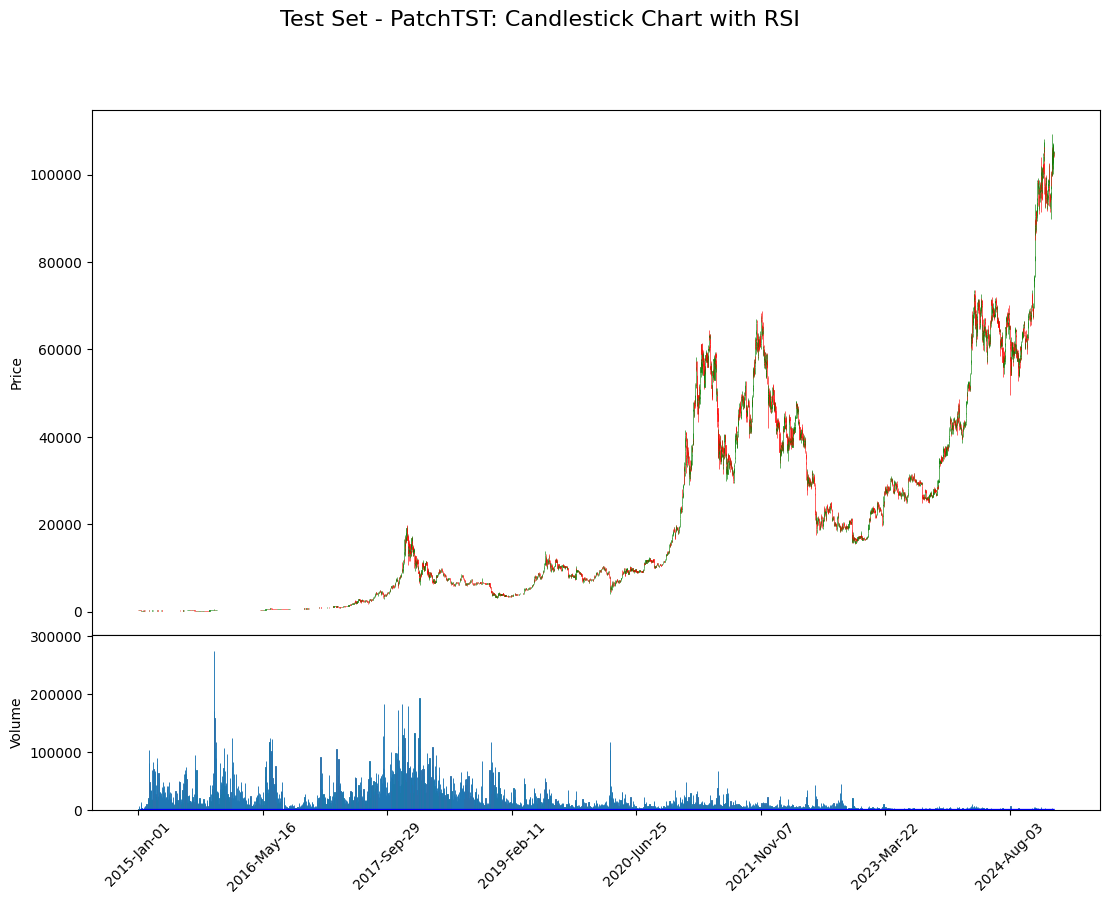

In [ ]:
# Plotting test set predictions: Prices and RSI
indices = np.arange(len(actual_test))
plt.figure(figsize=(14, 10))
if target == 'price':
    plt.subplot(2, 1, 1)
    plt.plot(indices, actual_test, label='Actual Price', marker='o', linestyle='-', color='blue')
    plt.plot(indices, preds_test, label='Predicted Price', marker='x', linestyle='--', color='red')
    if include_baseline:
        plt.plot(indices, y_baseline_test, label='Baseline Prediction', marker='s', linestyle=':', color='green')
    plt.xlabel('Sample Index', fontsize=14)
    plt.ylabel('Price', fontsize=14)
    plt.title(f"Test Set - {model_name}: Actual vs Predicted Prices", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.subplot(2, 1, 2)
    if len(actual_test) >= 14:
        rsi_actual = compute_rsi(actual_test, period=14)
        rsi_pred = compute_rsi(preds_test, period=14)
        plt.plot(indices, rsi_actual, label='Actual RSI', marker='o', linestyle='-', color='blue')
        plt.plot(indices, rsi_pred, label='Predicted RSI', marker='x', linestyle='--', color='red')
        plt.xlabel('Sample Index', fontsize=14)
        plt.ylabel('RSI', fontsize=14)
        plt.title(f"Test Set - {model_name}: RSI Comparison", fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, 'Not enough data for RSI calculation', fontsize=14, ha='center')
    plt.tight_layout()
    test_plot_filename = f"{csv_base}_{forecast_history}_{forecast_horizon}_test_plot.png"
    test_plot_path = result_history_dir / test_plot_filename
    plt.savefig(test_plot_path)
    plt.show()
    plt.close()
    log_print(f"Test prediction plot saved to '{test_plot_path}'")

# Create candlestick chart with RSI for the test period (using full data)
df_candle = df_raw.copy()
df_candle[datetime_col] = pd.to_datetime(df_candle[datetime_col])
df_candle = df_candle.sort_values(by=datetime_col)
if 'Price' in df_candle.columns:
    df_candle.rename(columns={'Price': 'Close'}, inplace=True)
# Check if volume data exists in your DataFrame. If the column is named "Vol.", rename it to "Volume"
if 'Vol.' in df_candle.columns:
    df_candle.rename(columns={'Vol.': 'Volume'}, inplace=True)
    df_candle['Volume'] = df_candle['Volume'].apply(lambda x: float(x.replace('K',''))*1000 if isinstance(x, str) and 'K' in x else float(x))
df_candle.set_index(datetime_col, inplace=True)
rsi_values = compute_rsi(df_candle['Close'].values, period=14)
df_candle['RSI'] = rsi_values
apds = [mpf.make_addplot(df_candle['RSI'], panel=1, color='blue', ylabel='RSI')]
mc = mpf.make_marketcolors(up='g', down='r', inherit=True)
s  = mpf.make_mpf_style(marketcolors=mc)
# Plot volume if available; otherwise, volume=False
volume_flag = True if 'Volume' in df_candle.columns else False
fig, axlist = mpf.plot(df_candle, type='candle', style=s, volume=volume_flag,
                        addplot=apds, returnfig=True, figsize=(14,10), panel_ratios=(3,1))
fig.suptitle(f"Test Set - {model_name}: Candlestick Chart with RSI", fontsize=16)
candle_plot_filename = f"{csv_base}_{forecast_history}_{forecast_horizon}_candlestick.png"
candle_plot_path = result_history_dir / candle_plot_filename
fig.savefig(candle_plot_path)
plt.show()
plt.close(fig)